#Приближенное интегрирование

Задача:

1. Рассчитать интегральный перенос воды на гидрологическом разрезе: для двух компонент скорости отдельно (Ve - восточная компонента вектора скорости течения, Vn - северная).
2. Реализовать 3 метода расчета интеграла:
  * метод прямоугольников (левых, правых);
  * метод трапеций;
  * метод Симпсона.

Интеграл двойной - считаем как два одинарных:
  * Сначала по всем вертикальным измерениям (фиксируем станцию, интегрируем по глубине).
  * Затем интегрируем по пространству (по всем станциям).

Расстояние между станциями рассчитать из координат. Координаты - в градусах, глубины - в метрах. Привести в единую СИ.

In [ ]:
import pandas as pd
import numpy as np

###Вычисление расстояния между двумя точками на поверхности Земли

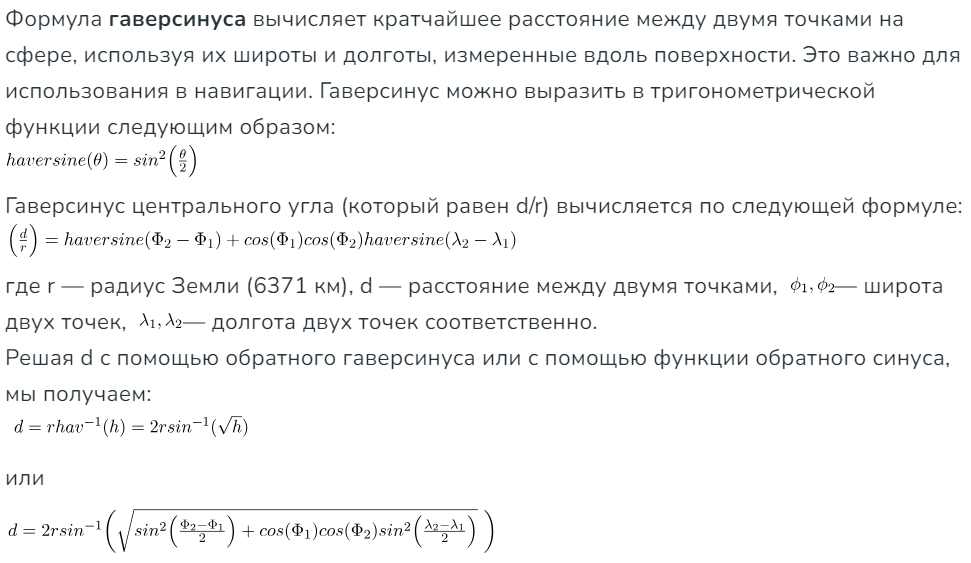

In [ ]:
def get_haversine(lat1, lon1, lat2, lon2):
    R = 6371000 # радиус Земли (в метрах)

    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)

    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c # расстояние (в метрах)

###Приближённые методы вычисления определённых интегралов

In [ ]:
def get_left_rectangle_integration(x, y):
  integral_sum = 0

  for i in range(len(x) - 1):
    integral_sum += y[i] * (x[i + 1] - x[i])

  return integral_sum

In [ ]:
def get_right_rectangle_integration(x, y):
  integral_sum = 0

  for i in range(1, len(x)):
    integral_sum += y[i] * (x[i] - x[i - 1])

  return integral_sum

In [ ]:
def get_trapezoid_integration(x, y):
  integral_sum = 0

  for i in range(len(x) - 1):
    integral_sum += 0.5 * (y[i] + y[i + 1]) * (x[i + 1] - x[i])

  return integral_sum

In [ ]:
def get_Simpson_integration(x, y):
  integral_sum = 0

  if len(y) >= 3:
      while len(y) % 3 != 0:
        y = y[0:len(y)-1]
        x = x[0:len(x)-1]

      integral_sum = y[0] * (x[1] - x[0])

      for i in range(1, len(y) - 1, 2):
        integral_sum += 2 * y[i] * (x[i + 1] - x[i])

      if len(y) >= 6:
        for i in range(2, len(y) - 1, 2):
          integral_sum += 4 * y[i] * (x[i + 1] - x[i])

      integral_sum += y[-1] * (x[-1] - x[-2])
      integral_sum = integral_sum / 3

  else:
      integral_sum = 0

  return integral_sum

###Поиск интегральных значений переноса воды на гидрологическом разрезе: для двух компонент скорости отдельно (Ve - восточная компонента вектора скорости течения, Vn - северная)

V(h) - скорость переноса воды.

In [ ]:
data = pd.read_table('data.txt', sep='\s+', engine='python')

####Интеграл по глубине

In [ ]:
internal_integral = []

In [ ]:
def get_internal_integral(x, y):
  left_rectangle = get_left_rectangle_integration(x, y)
  right_rectangle = get_right_rectangle_integration(x, y)
  trapezoid = get_trapezoid_integration(x, y)
  Simpson = get_Simpson_integration(x, y)

  return left_rectangle, right_rectangle, trapezoid, Simpson

In [ ]:
for station_id in data['Station'].unique():
    station_data = data[data['Station'] == station_id].sort_values('Depth').reset_index(drop=True)

    depths = station_data['Depth'].values
    ve = station_data['Ve'].values
    vn = station_data['Vn'].values

    ve_internal_integral = get_internal_integral(depths, ve)
    vn_internal_integral = get_internal_integral(depths, vn)

    internal_integral.append({
        'Station': station_id,
        'Integral_Transfer_Ve_Left_Rect': ve_internal_integral[0],
        'Integral_Transfer_Ve_Right_Rect': ve_internal_integral[1],
        'Integral_Transfer_Ve_Trapezoid': ve_internal_integral[2],
        'Integral_Transfer_Ve_Simpson': ve_internal_integral[3],
        'Integral_Transfer_Vn_Left_Rect': vn_internal_integral[0],
        'Integral_Transfer_Vn_Right_Rect': vn_internal_integral[1],
        'Integral_Transfer_Vn_Trapezoid': vn_internal_integral[2],
        'Integral_Transfer_Vn_Simpson': vn_internal_integral[3],
    })

In [ ]:
internal_integral_df = pd.DataFrame(internal_integral).sort_values('Station').reset_index(drop=True)

In [ ]:
for i in range(len(internal_integral_df) - 1):
    if i == len(internal_integral_df) - 1: #если станция последняя, то ищем расстояние между первой и последней
        lat1 = data[data['Station'] == internal_integral_df['Station'].iloc[-1]]['Latitude'].iloc[0]
        lon1 = data[data['Station'] == internal_integral_df['Station'].iloc[-1]]['Longitude'].iloc[0]
        lat2 = data[data['Station'] == internal_integral_df['Station'].iloc[0]]['Latitude'].iloc[0]
        lon2 = data[data['Station'] == internal_integral_df['Station'].iloc[0]]['Longitude'].iloc[0]

        distance = get_haversine(lat1, lon1, lat2, lon2)
        internal_integral_df.loc[i, 'Distance'] = distance # добавляем расстояние в DataFrame

    lat1 = data[data['Station'] == internal_integral_df['Station'].iloc[i]]['Latitude'].iloc[0]
    lon1 = data[data['Station'] == internal_integral_df['Station'].iloc[i]]['Longitude'].iloc[0]
    lat2 = data[data['Station'] == internal_integral_df['Station'].iloc[i+1]]['Latitude'].iloc[0]
    lon2 = data[data['Station'] == internal_integral_df['Station'].iloc[i+1]]['Longitude'].iloc[0]

    distance = get_haversine(lat1, lon1, lat2, lon2)
    internal_integral_df.loc[i, 'Distance'] = distance

In [ ]:
internal_integral_df = internal_integral_df.groupby('Station').apply(lambda x: x.sort_values('Distance')).reset_index(drop=True)#сортировка по расстоянию между станциями

<ipython-input-20-458ddee16977>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  internal_integral_df = internal_integral_df.groupby('Station').apply(lambda x: x.sort_values('Distance')).reset_index(drop=True)#сортировка по расстоянию между станциями


####Интеграл по пространству

In [ ]:
integral_transfer_ve_trapezoid = 0
for i in range(len(internal_integral_df) - 1):
    distance = internal_integral_df['Distance'].iloc[i]
    integral_transfer_ve_trapezoid += 0.5 * (internal_integral_df['Integral_Transfer_Ve_Trapezoid'].iloc[i] + internal_integral_df['Integral_Transfer_Ve_Trapezoid'].iloc[i+1]) * distance

integral_transfer_vn_trapezoid = 0
for i in range(len(internal_integral_df) - 1):
    distance = internal_integral_df['Distance'].iloc[i]
    integral_transfer_vn_trapezoid += 0.5 * (internal_integral_df['Integral_Transfer_Vn_Trapezoid'].iloc[i] + internal_integral_df['Integral_Transfer_Vn_Trapezoid'].iloc[i+1]) * distance

results_df = internal_integral_df
results_df.loc[0,'Integral_Transfer_Ve_Trapezoid_Space'] = integral_transfer_ve_trapezoid
results_df.loc[0,'Integral_Transfer_Vn_Trapezoid_Space'] = integral_transfer_vn_trapezoid
results_df.to_csv('integral_water_transfer_results.csv', index=False)

print("Расчеты завершены, результаты сохранены в 'integral_water_transfer_results.csv'")
print("Интегральный расчет переноса воды находится в столбиках Integral_Transfer_Ve_Trapezoid_Space и Integral_Transfer_Vn_Trapezoid_Space")
print(integral_transfer_ve_trapezoid)
print(integral_transfer_vn_trapezoid)

Расчеты завершены, результаты сохранены в 'integral_water_transfer_results.csv'
Интегральный расчет переноса воды находится в столбиках Integral_Transfer_Ve_Trapezoid_Space и Integral_Transfer_Vn_Trapezoid_Space
1409615.241497932
-566882.1483496511
